# 機械学習手法のパイプライン化

In [9]:
%matplotlib inline
from IPython.display import Image
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
df.shape

(569, 32)

In [5]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0])

In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.20, random_state=1)

---
### 標準化+PCA+ロジスティック回帰 をパイプライン化した例

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])

pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
y_pred = pipe_lr.predict(X_test)

Test Accuracy: 0.947


fitする時とpredictする時で内部で呼び出されているメソッドが違うことに気をつける。下にパイプラインの動作の様子が分かる図を示す。

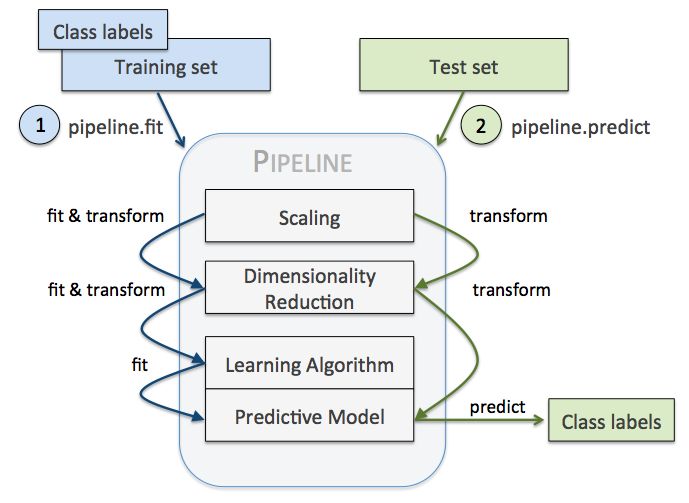

In [12]:
Image(filename='./images/06_01.png', width=400) 

---
# クロスバリデーション

K分割クロスバリデーションは訓練データセットをK個のグループに分け、そのうちの一つをテストデータグループとしてモデルのパラメータ検証を行うのを非復元抽出で繰り返す手法。
分割数は多くなればなるほど、検証によって得られたパラメータの妥当性は上がるが、計算コストは上がる。テストデータを一つずつ分割していくのは、高妥当性、高コストの究極で、LOOCVと呼ばれる。
LOOCVは小さいデータセットを扱う際に推奨される。

ここで注意点として、モデルの検証にテストデータを用いてはいけないということがある。また、クロスバリデーションによって得られた最適なパラメータを用いて、バリデーションセットも一緒に、つまり訓練データ全てを用いて学習させる必要がある。（ここでもテストデータを用いて学習するのはNG。適切なモデル評価を行うために、テストデータは最後の最後まで取っておく。）

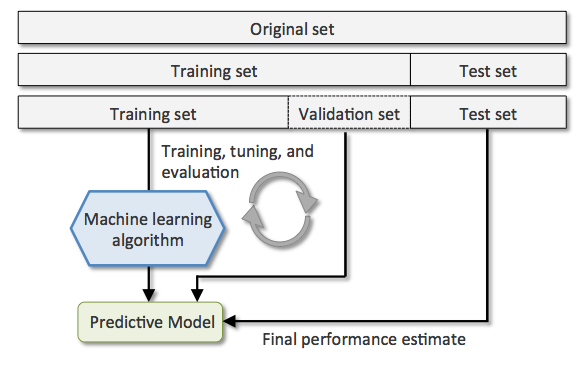

In [15]:
Image(filename='./images/06_02.png', width=400) 

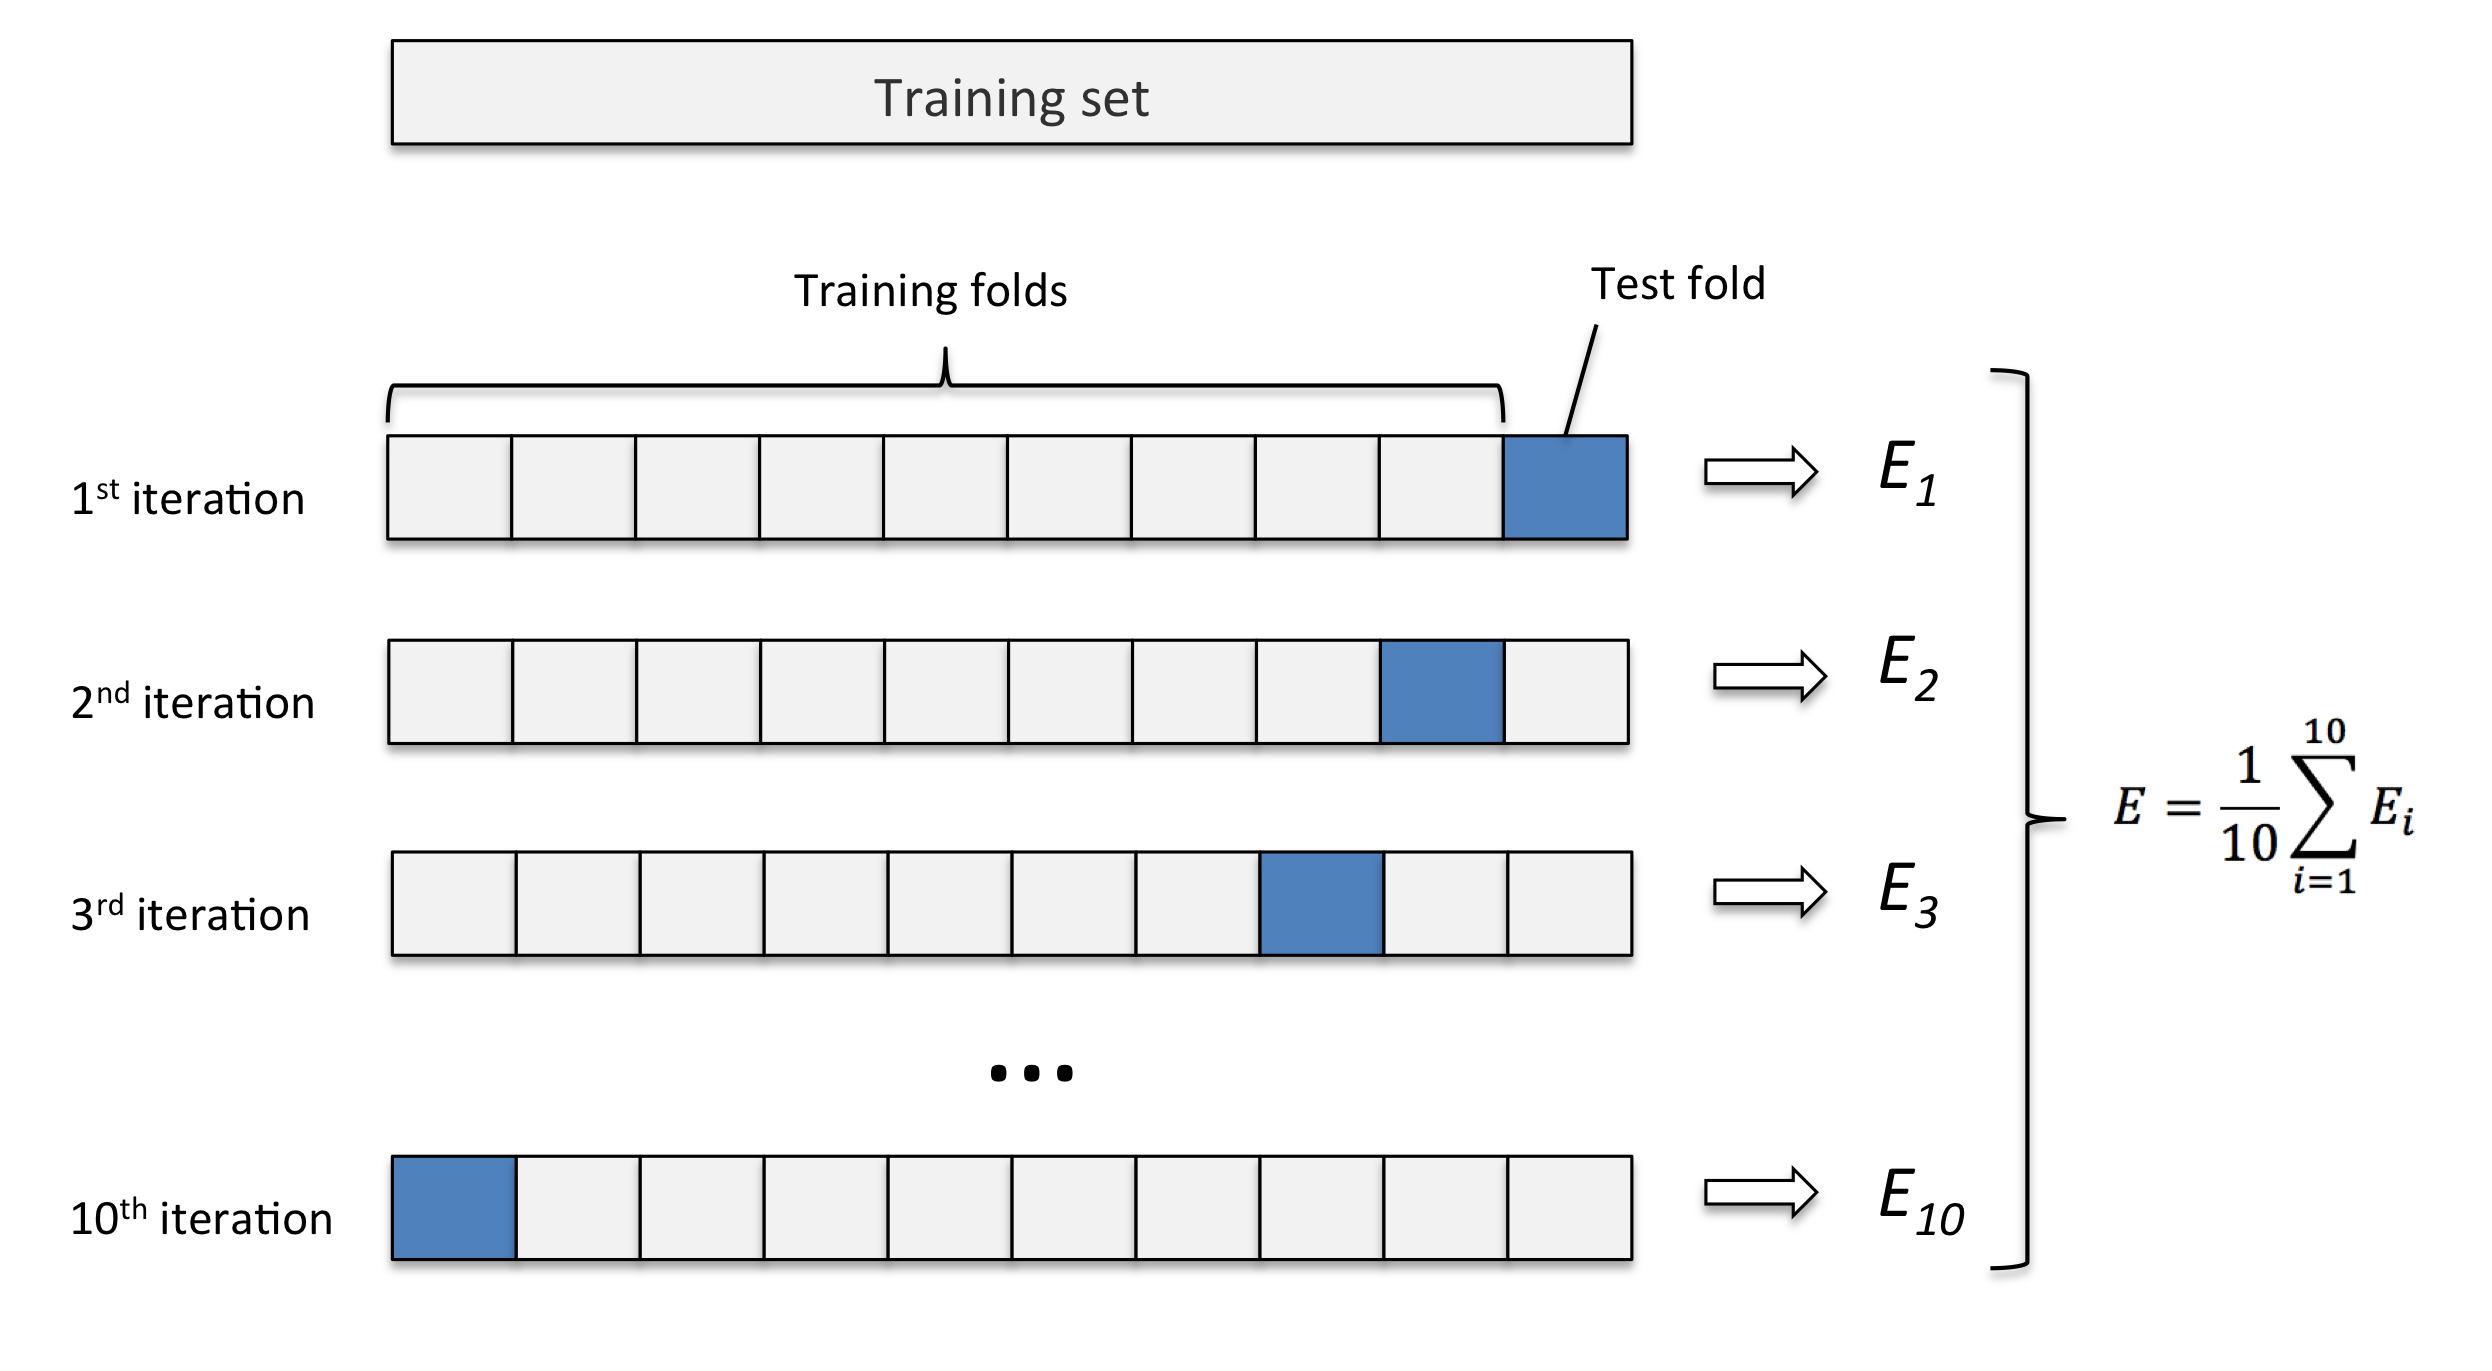

In [16]:
Image(filename='./images/06_03.png', width=500) 

**stratified k-fold cross validation(層化k分割交差検証)** という手法もある。この手法は通常のk-fold交差検証とは異なり、分割後のサブセットのクラス比率が、元の訓練データ全体のクラス比率と等しくなるようにデータが分割される。よって、クラスによってデータのサイズにバラつきがあるときに威力を発揮する。

下がscikit-learnを用いた例である。

In [17]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

kfold = StratifiedKFold(y=y_train, 
                        n_folds=10,
                        random_state=1)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.029


In [21]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=2)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


---
# 学習曲線、検証曲線
バイアスとバリアンスはトレードオフの関係にあり、最良のバランスになるようにモデルの複雑さを決定する必要がある。
それらの決定に有効なのがサンプル数に応じたバイアスバリアンスの関係をプロットしてみることである。

/Users/yoko/.anyenv/envs/pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


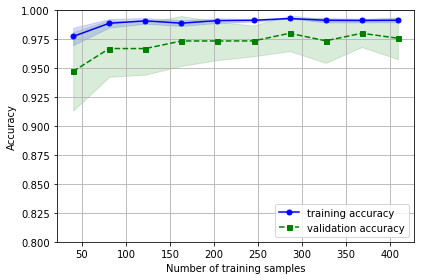

In [22]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])

# デフォルトは層化k分割　train_sizesにはデータセットの10%,20%,...,100%の割合で学習
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

上の図はデータセットのサイズでプロットしたものであるが、正則化パラメータの大きさでプロットしたい場合も多い。そんな時は"**validation_curve()**"メソッドを使う。

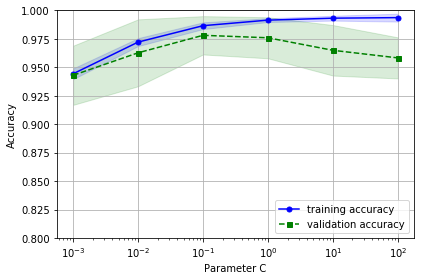

In [24]:
from sklearn.learning_curve import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

---
## グリッドサーチで最適なハイパーパラメーターを探索する
モデルの正則化パラメーターや、決定木の深さなどは、ハイパーパラメーターと呼ばれ、学習によって得られるパラメーターとは異なるものである。適切なハイパーパラメーターを得るための手法として、「グリッドサーチ」があり、scikit-learnにも用意されている。

グリッドサーチはハイパーパラメーターの最適な値の組み合わせを、指定された値の範囲からしらみつぶしに探索する。つまり、探索するパラメーターの範囲が増えれば増えるほど、指数的に計算コストが増えることに注意する必要がある。

また、ランダムサーチを使用するという方法もある。（RandomizedSearchCV）

In [25]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'clf__C': param_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': param_range, 
                  'clf__gamma': param_range, 
                  'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

/Users/yoko/.anyenv/envs/pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [26]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


<br>
上記のように、線形SVMとガウスカーネルSVMを同時にサーチすることも可能である。サーチして得られた結果はGridSearchCVクラスのインスタンスの変数からアクセスすることが出来る。
上の例ではグリッドサーチの結果、「C=0.1のときの線形SVM」が最も良いパフォーマンスが得られることが分かった。

---
グリッドサーチした時の各パラメーターに対する精度にもアクセスすることが出来る。

In [29]:
gs.grid_scores_[:5]

[mean: 0.64176, std: 0.01710, params: {'clf__C': 0.0001, 'clf__kernel': 'linear'},
 mean: 0.93846, std: 0.02354, params: {'clf__C': 0.001, 'clf__kernel': 'linear'},
 mean: 0.96044, std: 0.02349, params: {'clf__C': 0.01, 'clf__kernel': 'linear'},
 mean: 0.97802, std: 0.01955, params: {'clf__C': 0.1, 'clf__kernel': 'linear'},
 mean: 0.97582, std: 0.02286, params: {'clf__C': 1.0, 'clf__kernel': 'linear'}]

---
## 入れ子式の交差検証

交差検証とグリッドサーチを組み合わせて入れ子にする方法もある。
入れ子式の交差検証による誤差推定はとても正確で、テストデータを評価したときとのバイアスはとても小さいものになる。

（※実はグリッドサーチも内部で交差検証を行っているので組み合わせるという表現は微妙かも）

具体的に5-fold CVとグリッドサーチ（2-fold）を組み合わせた例について図とコードで示す。この例の方法は「5×2交差検証」とも呼ばれる。

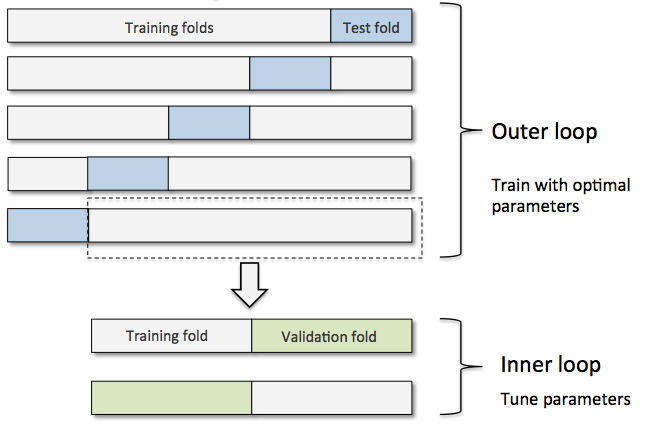

In [30]:
Image(filename='./images/06_07.png', width=500) 

In [31]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [32]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.029


この例ではSVM＞決定木となった

---

# 性能評価指標

今までは性能評価の指標として、正答率（accuracy）を使ってきたが、他にも再現率や適合率、F1スコアなどがある。どれもモデルの性能を定量的に扱うことが出来るような指標となっている。

それぞれについて説明する前に混同行列について見てみる。
二値分類の際、「本当は真で予測値も真」、「本当は真で予測値は偽」、そして「本当は偽だったとき」で同様に2パターン、計4パターンがある。それぞれ「真陽性(TP)
」、「偽陽性(FP)」、「真陰性(TF)」、「偽陰性(FN)」と呼ばれる。
「偽」が頭に付いてるものは誤分類されたデータを表す。例えば「偽陽性」は、陽性と予測器が判断したのに実際は違っていたケースを表している。

この章で今まで取り扱ってきたデータセットをSVMで判定したときの混同行列を可視化するコードを以下に示す。

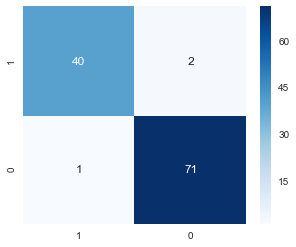

In [50]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
labels = [1, 0]
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=labels)
df_conf = pd.DataFrame(confmat, index=labels, columns=labels)
plt.figure(figsize=(5,4))
seaborn.heatmap(df_conf, annot=True, fmt='g', cmap='Blues')

---
混同行列から計算できる指標として、「真陽性率(TPR)」と「偽陽性率(FPR)」が不均衡データでとても重要になってくる。

$$
TPR = \frac{TP}{P} = \frac{TP}{TP + FN}
$$

$$
FPR = \frac{FP}{N} = \frac{FP}{FP + TN}
$$

例えば、重病に羅患しているかどうかを判断したいときは、一般的に羅患している患者の数は圧倒的に少数派であることが考えられる。
そのような場合、予測器がただ「全員健康」と判断した場合に、「正答率」の観点からすると優れた予測器と評価されてしまう。
このケースでは、実は羅患している（陽性）のに健康と判断してしまう（FN）ことがマズイ。よって真陽性率が予測器の性能評価に適していると言える。


適合率(PRE)と再現率(REC)は、TPRとFPRに関する性能指標である。PREは陽性と判断したサンプルのうち、本当に陽性だったサンプルの割合を示していて、RECはTPRの同義語である。PREとRECを組み合わせたF1スコア（F値）と呼ばれる指標がよく使われる。F1スコアはPREとRECの調和平均になっている。

$$
PRE = \frac{TP}{TP + FP}
$$

$$
F1 = 2\frac{PRE \times REC}{PRE + REC}
$$

これらの指標はscikit-learnのmetricsモジュールからインポート出来る。
また、これらの指標をグリッドサーチのscoringという引数で指定することで使用することも出来る。

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


---
## ROC曲線
モデルの性能をグラフで表現するツールの一つ。横軸にFPR、縦軸にTPRが設定される。
scikit-learnを用いてROC曲線を描画してみる。

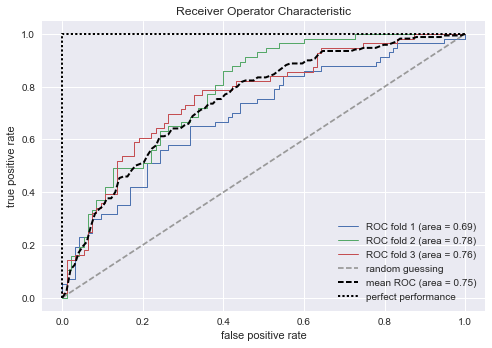

In [52]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

X_train2 = X_train[:, [4, 14]]

cv = StratifiedKFold(y_train, n_folds=3, random_state=1)

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

ここで、斜めの(0,0),(1,1)を結ぶ線はランダム予測した場合のROC曲線となっていて、左上の隅を通る点線は誤分類をしない完璧な分類器が描くROC曲線となっている。
ROC曲線の内側の領域の面積をAUCと呼び、AUCの値が高いほど、モデルの性能が良いことを意味している。AUCは正解率と類似している。

In [54]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


適合率(PRE)は他クラス分類問題にも拡張することが出来る。
scikit-learnでも、「一対他」の考え方により、二値分類のときと同じようにスコアを計算することが出来る。実際にスコアを計算するときは、average引数に、マイクロ平均法('micro')を使用するのか、マクロ平均法('macro')を使用するのか、重み付けされたマクロ平均法を使用するのかを指定する。

それぞれこのような特性がある。
* マイクロ平均法：全クラスの陽性サンプルを、分類器が陽性と判断したサンプル数で割ったもの。クラスを分け隔てなく考えるため、サンプル数に偏りがあった場合、サンプル数が多いクラスの結果にスコアが引っ張られる。
* マクロ平均法：全てのクラスごとの適合率の平均。全てのクラスを平等に扱うことが出来る。つまり、クラスごとにサンプル数に偏りがあった場合でも、サンプル数が多いクラスの結果にスコアが引っ張られることが無い。
* 重み付けマクロ平均法：マクロ平均法に、各クラスのサンプル数で正規化する方法。マイクロ平均法と近い。